<!--

Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

-->

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://github.com/GoogleCloudPlatform/medlm-embedding-cxr/raw/main/notebook.ipynb">
      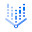
      Run in Vertex AI Workbench
    </a>
    </td>
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/medlm-embedding-cxr/blob/main/notebook.ipynb">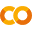
    Run in Colab
    </a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/medlm-embedding-cxr/">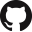
    View on GitHub
    </a>
  </td>
</table>

# Google Cloud MedLM Embedding API For CXR

Once you have labeled datasets we will ingest them in Healthcare API, use BigQuery to filter the cohorts of information, retrieve the relevant labeled images, train using the CXR foundation model, and ultimately test our trained model on staged data.

### Prerequisites

- Make sure you have been granted access to the MedLM Embedding API For CXR by filling out [this](https://docs.google.com/forms/d/e/1FAIpQLSd-fBqL-Ox5Qqmr6Q7nRo2oTfbttgdr700-XjSV4GEKYhbicg/viewform) form.
- After you've been given access to the API, you only have to change the `PROJECT_ID` value below to your own project, and then you can Run All cells.
- Code was tested with Python v3.10.6 in VSCode, Vertex AI Workbench, and Colab

In [ ]:
import random, sys, time, os

# You must update the variables in this section
PROJECT_ID = "[CHANGEME]"  # @param {type: 'string'}

# Consts for your GCP environment
RAND = random.randint(1,100000)
LOCATION = "us-central1" # This region required for early access.
DATASET_ID = f"dataset_{RAND}"
STORE_ID = "store_id"
HCAPI_HOST = f"https://healthcare.googleapis.com/v1/projects/{PROJECT_ID}/locations/{LOCATION}/datasets/{DATASET_ID}/dicomStores/{STORE_ID}"
DICOMWEB_HOST = f"{HCAPI_HOST}/dicomWeb"
BQ_TABLE_ID = "metadata"
BQ_TABLE = f"{PROJECT_ID}.{DATASET_ID}.{BQ_TABLE_ID}"
VERTEX_ENDPOINT_ID = f"cxr-endpoint-{RAND}"
MODEL_BUCKET_NAME = f"cxr_model_bucket_{RAND}"

# Other Consts
DIAGNOSIS = "PNEUMOTHORAX"
STAGED_DIR = "./data/staged/"
EMBEDDINGS_DIR = "./data/outputs"
MODEL_DIR = "./data/outputs/model"
MIN_STUDIES = 195
EMBEDDING_KEY = 'embedding'
EMBEDDINGS_SIZE = 32 * 768 # dimensional vector

# Authenticate; will only run if you're in Colab
if "google.colab" in sys.modules:
    from google.colab import auth

    # Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
    auth.authenticate_user()

# Some basic input validation
if PROJECT_ID == "[CHANGEME]":
    raise ValueError("Please provide your own value for PROJECT_ID")

### Environment setup


In addition to installing some local python packages, this will use Terraform to set up a [Healthcare API DICOM store](https://cloud.google.com/healthcare-api/docs/how-tos/dicom#creating_a_dicom_store), [BigQuery table](https://cloud.google.com/bigquery/docs/tables), and [streaming](https://cloud.google.com/healthcare-api/docs/how-tos/dicom-bigquery-streaming) of metadata from Healthcare API DICOM store to a BigQuery table. Additionally it will setup a Google Cloud Storage bucket to copy your model and it will create a Vertex AI Online Prediction endpoint to host the model you will eventually build. 

**NOTE:** Please enable all the appropriate APIs based on the above list. Additionally, you must grant the bigquery.dataEditor role to your project's Cloud Healthcare Service Agent, in order to have metadata streamed from Healthcare API DICOM store to BigQuery.

In [ ]:
%%bash -s "$LOCATION" "$PROJECT_ID" "$DATASET_ID" "$STORE_ID" "$BQ_TABLE_ID" "$VERTEX_ENDPOINT_ID" "$MODEL_BUCKET_NAME" "$STAGED_DIR"

# Python packages
pip install db-dtypes scikit-learn "tf-models-official>=2.13.0"

# Package for CXR foundation model wrapper
CXR_COMMIT='6c284364e3883353ed737545e475a1016620fd7e' # tested version locked
CXR_URL=https://github.com/Google-Health/imaging-research/archive/${CXR_COMMIT}.zip
if ! test -d imaging-research-${CXR_COMMIT}; then
    curl -L -o imaging-research-${CXR_COMMIT}.zip ${CXR_URL}
    unzip -o imaging-research-${CXR_COMMIT}.zip
    pip install imaging-research-${CXR_COMMIT}/cxr-foundation/
    rm -rf imaging-research-${CXR_COMMIT}.zip
fi

# Retrieve staged data
if ! test -d data; then
    mkdir -p data/staged
    gsutil -m cp -r gs://mis-ai-accelerator/data/staged/*.dcm data/staged/
fi

# Retrieve terraform executable and scripts locally
TF_URL=https://releases.hashicorp.com/terraform/1.6.1/terraform_1.6.1_linux_amd64.zip
if ! test -f terraform; then
    curl -so terraform.zip ${TF_URL}
    unzip terraform.zip
    rm -rf terraform.zip
    gsutil -m cp -r gs://mis-ai-accelerator/tf .
fi

# Deploy terraform
./terraform -chdir=./tf init
./terraform -chdir=./tf plan -var="project_id=$2" -var="location=$1" -var="dataset_id=$3" -var="store_id=$4" -var="table_id=$5" -var="vertex_endpoint_name=$6" -var="gcs_bucket_name=$7" -out tf.plan
./terraform -chdir=./tf apply tf.plan

# Label the environment, if it is GCE
STATUS_CODE=$(curl --write-out %{http_code} --silent --output /dev/null metadata)
if [[ "${STATUS_CODE}" -eq 200 ]]; then
    VMNAME=$(curl -H Metadata-Flavor:Google metadata/computeMetadata/v1/instance/hostname | cut -d. -f1)
    ZONE=$(curl -H Metadata-Flavor:Google metadata/computeMetadata/v1/instance/zone | cut -d/ -f4)
    gcloud compute instances update ${VMNAME} --zone=${ZONE} --update-labels=goog-packaged-solution=medical-imaging-suite
    echo "Set label on ${VMNAME}"
else
    echo "Skipping label since not inside a GCE instance."
fi

# Import into Healthcare API, so embeddings API can access DICOM images
gcloud healthcare dicom-stores import gcs $4 --dataset=$3 --project=$2 --location=$1 --gcs-uri="gs://mis-ai-accelerator/data/staged/inputs/*.dcm"

## Map labels from DICOM using BigQuery

Execute a query against BQ to get the list of DICOM instances that are positive and negative for Pneumothorax, based on presence of KOS.

**NOTE:** If you've just recently pushed a bunch of images to the Healthcare API DICOM Store, then it might take a few seconds to propagate the metadata to BigQuery. You can configure how long this section retries for.


In [ ]:
from google.cloud import bigquery

# Initialize our BigQuery client (need project ID for Colab)
bq_client = bigquery.Client(project=PROJECT_ID)

#   DICOM types
#   Key Object Selection Document, SOPClassUID=1.2.840.10008.5.1.4.1.1.88.59, Modality=KO
#   Secondary Capture Image Storage, SOPClassUID=1.2.840.10008.5.1.4.1.1.7, Modality=DX

query = """
SELECT
  StudyInstanceUID,
  SeriesInstanceUID,
  SOPInstanceUID,
  CAST (CAST (StudyInstanceUID IN (
      SELECT
        DISTINCT StudyInstanceUID
      FROM
        `{}`
      WHERE
        SOPClassUID='1.2.840.10008.5.1.4.1.1.88.59'
        AND Modality='KO') AS INT64) AS FLOAT64) AS {}
FROM
  `{}`
WHERE
  SOPClassUID='1.2.840.10008.5.1.4.1.1.7'
  AND Modality='DX'
""".format(
    BQ_TABLE, DIAGNOSIS, BQ_TABLE
)

bq_job_config = bigquery.QueryJobConfig(use_query_cache=False)

# Waiting for BQ to be populated with enough metadata
totalWait, INCREMENT, MAX_WAIT = 0, 30, 1200  # Max wait = 20 mins!
while True:
    bq_df = bq_client.query(query, bq_job_config).to_dataframe()
    if len(bq_df) >= MIN_STUDIES:
        print(f"Completed populating BQ! ({totalWait} sec)")
        break
    print(f"Progress populating BQ: {len(bq_df)}/{MIN_STUDIES} ({totalWait} sec)")
    totalWait += INCREMENT
    if totalWait >= MAX_WAIT:
        raise ValueError(
            f"Max time elapsed populating BQ! Please try this cell again. Progress: {len(bq_df)}/{MIN_STUDIES}"
        )
    time.sleep(INCREMENT)

# Paths for generated embeddings
bq_df["embedding_file"] = bq_df["SOPInstanceUID"].apply(
    lambda x: os.path.join(EMBEDDINGS_DIR, x + ".tfrecord")
)

display(bq_df.tail())

## Generate embeddings for all DICOM images

Call the MedLM Embedding API For CXR with a reference to each DICOM image in the Healthcare API DICOM store, generate an embedding, and store it locally for use in training later. This may take ~15 mins, depending on data being sent, your connection latency, and load on server. You may think of embeddings as compressed raster images, in a format efficient for model training.

**IMPORTANT:** You must have access to use the MedLM Embedding API for CXR. For access, please fill out [this](https://docs.google.com/forms/d/e/1FAIpQLSd-fBqL-Ox5Qqmr6Q7nRo2oTfbttgdr700-XjSV4GEKYhbicg/viewform) form.

In [ ]:
import numpy as np
import tensorflow as tf
from google.auth.transport.requests import AuthorizedSession
import google.auth

_CXR_URL = f"https://{LOCATION}-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/medlm-embedding-cxr:predict"

credentials, _ = google.auth.default()
api_session = AuthorizedSession(credentials)


def retrieve_embedding_array(dicomUri: str) -> np.ndarray:
    json = {
        "instances": [{"dicomUri": dicomUri}],
    }

    while True:  # Basic retry, no limit for HTTP 429 (due to quota)
        response = api_session.post(_CXR_URL, json=json)
        if response.status_code == 429:
            time.sleep(5)
            continue
        if not response.ok:
            raise RuntimeError(f"Embedding creation call failed: {response.text}")
        break

    embed = response.json()["predictions"][0]["chestXRayEmbedding"]
    return np.array(embed, dtype=np.float32)


if not os.path.exists(EMBEDDINGS_DIR):
    os.makedirs(EMBEDDINGS_DIR)

i, total = 0, len(bq_df)
for _, row in bq_df.iterrows():
    i += 1
    if os.path.exists(row["embedding_file"]):
        print(f'[{i}/{total}] Embedding file exists; skipping: {row["embedding_file"]}')
        continue
    dicomUri = f'{DICOMWEB_HOST}/studies/{row["StudyInstanceUID"]}/series/{row["SeriesInstanceUID"]}/instances/{row["SOPInstanceUID"]}'
    arr = retrieve_embedding_array(dicomUri=dicomUri)
    example = tf.train.Example()
    example.features.feature[EMBEDDING_KEY].float_list.value[:] = arr.flatten()
    with tf.io.TFRecordWriter(row["embedding_file"]) as w:
        w.write(example.SerializeToString())

    print(f'[{i}/{total}] Generated embedding file: {row["embedding_file"]}')

print("Completed embedding file creation")

## Train A Model

Finally, we can train a model using the embeddings! With a simple feed-forward neural network, it should take < 5 minutes to train 100 epochs! No GPU required.


In [ ]:
import tensorflow_models as tfm
from typing import Iterable
from sklearn.model_selection import train_test_split


def parse_serialized_example_values(
    serialized_example: bytes,
) -> tf.Tensor:
    features = {
        EMBEDDING_KEY: tf.io.FixedLenFeature(
            [EMBEDDINGS_SIZE],
            tf.float32,
            default_value=tf.constant(0.0, shape=[EMBEDDINGS_SIZE]),
        )
    }
    parsed_tensors = tf.io.parse_example(serialized_example, features=features)
    return parsed_tensors[EMBEDDING_KEY]


def get_dataset(filenames: Iterable[str], labels: Iterable[int]) -> tf.data.Dataset:
    ds_embeddings = tf.data.TFRecordDataset(
        filenames, num_parallel_reads=tf.data.AUTOTUNE
    ).map(parse_serialized_example_values)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels)

    return tf.data.Dataset.zip((ds_embeddings, ds_labels))


def create_model(
    heads,
    learning_rate=0.1,
    end_lr_factor=1.0,
    dropout=0.0,
    decay_steps=1000,
    loss_weights=None,
    hidden_layer_sizes=[512, 256],
    weight_decay=0.0,
    seed=None,
) -> tf.keras.Model:
    # Creates linear probe or multilayer perceptron using LARS + cosine decay.
    inputs = tf.keras.Input(shape=(32 * 768,))  # Based on ELIXR
    inputs_reshape = tf.keras.layers.Reshape((32, 768))(inputs)
    inputs_pooled = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_last")(
        inputs_reshape
    )
    hidden = inputs_pooled
    # If no hidden_layer_sizes are provided, model will be a linear probe.
    for size in hidden_layer_sizes:
        hidden = tf.keras.layers.Dense(
            size,
            activation="relu",
            kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
            kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
            bias_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
        )(hidden)
        hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = tf.keras.layers.Dropout(dropout, seed=seed)(hidden)
    output = tf.keras.layers.Dense(
        units=len(heads),
        activation="sigmoid",
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
    )(hidden)

    outputs = {}
    for i, head in enumerate(heads):
        outputs[head] = tf.keras.layers.Lambda(
            lambda x: x[..., i : i + 1], name=head.lower()
        )(output)

    model = tf.keras.Model(inputs, outputs)
    learning_rate_fn = tf.keras.experimental.CosineDecay(
        tf.cast(learning_rate, tf.float32),
        tf.cast(decay_steps, tf.float32),
        alpha=tf.cast(end_lr_factor, tf.float32),
    )
    model.compile(
        optimizer=tfm.optimization.lars.LARS(learning_rate=learning_rate_fn),
        loss=dict([(head, "binary_crossentropy") for head in heads]),
        loss_weights=loss_weights or dict([(head, 1.0) for head in heads]),
        weighted_metrics=[
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.FalseNegatives(),
            tf.keras.metrics.TruePositives(),
            tf.keras.metrics.TrueNegatives(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.AUC(curve="PR", name="auc_pr"),
        ],
    )
    return model


# Create train and validation split (train = 70%, validation = 30%)
df_train, df_validate = train_test_split(bq_df, train_size=0.7)

# Create training and validation datasets
training_data = get_dataset(
    filenames=df_train["embedding_file"].values, labels=df_train[DIAGNOSIS].values
)


validation_data = get_dataset(
    filenames=df_validate["embedding_file"].values, labels=df_validate[DIAGNOSIS].values
)

# Create and train the model
model = create_model([DIAGNOSIS])

model.fit(
    x=training_data.batch(512).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data.batch(1).cache(),
    epochs=100,
)

# Summary after training is complete
model.summary()

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# Save the model locally
tf.saved_model.save(model, MODEL_DIR)

## Examine metrics

Graph the metrics for the model based on validation data.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

rows = []
for embeddings, label in validation_data.batch(1):
    row = {
        f"{DIAGNOSIS}_prediction": model(embeddings)[DIAGNOSIS].numpy().flatten()[0],
        f"{DIAGNOSIS}_value": label.numpy().flatten()[0],
    }
    rows.append(row)
eval_df = pd.DataFrame(rows)
eval_df.head()

In [ ]:
%matplotlib inline
import sklearn


def plot_curve(x, y, auc, x_label=None, y_label=None, label=None):
  fig = plt.figure(figsize=(10, 10))
  plt.plot(x, y, label=f'{label} (AUC: %.3f)' % auc, color='black')
  plt.legend(loc='lower right', fontsize=18)
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  if x_label:
    plt.xlabel(x_label, fontsize=24)
  if y_label:
    plt.ylabel(y_label, fontsize=24)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(visible=True)

labels = eval_df[f'{DIAGNOSIS}_value'].values
predictions = eval_df[f'{DIAGNOSIS}_prediction'].values
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(
    labels,
    predictions,
    drop_intermediate=False)
auc = sklearn.metrics.roc_auc_score(labels, predictions)
plot_curve(false_positive_rate, true_positive_rate, auc, x_label='False Positive Rate', y_label='True Positive Rate', label=DIAGNOSIS)

## Deploy the model and test it
The following section shows how to deploy the exported model to GCP and then test inference by creating the embeddings API and then online prediction endpoint where your model is hosted.

**NOTE**: The deployment of the model to the endpoint could take ~15 mins.

In [ ]:
%%bash -s "$LOCATION" "$MODEL_DIR" "$MODEL_BUCKET_NAME" "$VERTEX_ENDPOINT_ID" "$PROJECT_ID"

MODEL_NAME=cxr-model

echo Copying model to GCS bucket
gsutil cp -r $2 gs://$3

echo Uploading the model to Vertex AI Model Registry 
gcloud ai models upload \
  --project=$5 \
  --region=$1 \
  --display-name=$MODEL_NAME \
  --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-13:latest \
  --artifact-uri=gs://$3/model
MODEL_ID=$(gcloud ai models list --project=$5 --region=$1 | grep $MODEL_NAME | awk '{print $1}' | head -1)
echo ModelID: $MODEL_ID

echo Hosting the model on a Vertex AI endpoint
gcloud ai endpoints deploy-model $4 \
  --project=$5 \
  --region=$1 \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --traffic-split=0=100

## Run predictions on images

In [ ]:
%matplotlib inline

import pydicom
import matplotlib.pyplot as plt

_MY_MODEL_URL = f"https://{LOCATION}-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/{LOCATION}/endpoints/{VERTEX_ENDPOINT_ID}:predict"


def get_online_prediction(instance):
    # Call CXR to generate embeddings
    input = retrieve_embedding_array(dicomUri=instance)
    json = { "instances": input.reshape(1, EMBEDDINGS_SIZE).tolist() }
    # Call my model with the embedding and get prediction
    response = api_session.post(_MY_MODEL_URL, json=json)
    if not response.ok:
        raise RuntimeError(f"Prediction call failed: {response.content}")
    res = response.json()
    return res

# Postive prediction
pos_file = STAGED_DIR + "positive.dcm"
pos_instance = f'{DICOMWEB_HOST}/studies/1.3.6.1.4.1.11129.5.5.125244073909057181345738889085284198099651/series/1.3.6.1.4.1.11129.5.5.138502690012449501224934835894513332244191/instances/1.3.6.1.4.1.11129.5.5.144821354400097386866710469118057421849850'
pos_predict = get_online_prediction(pos_instance)

# Negative prediction
neg_file = STAGED_DIR + "negative.dcm"
neg_instance = f'{DICOMWEB_HOST}/studies/1.3.6.1.4.1.11129.5.5.195421166273048982066192993508222383663074/series/1.3.6.1.4.1.11129.5.5.131098996341768723770121426857691412090508/instances/1.3.6.1.4.1.11129.5.5.164778748062349548634537702002731919155437'
neg_predict = get_online_prediction(neg_instance)

# Display images
_, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(pydicom.dcmread(pos_file).pixel_array, cmap='gray')
axes[0].set_title(f"\"Positive\" {DIAGNOSIS.lower()} prediction: {pos_predict['predictions'][0][0]:.3f}")
axes[0].set_axis_off()
axes[1].imshow(pydicom.dcmread(neg_file).pixel_array, cmap='gray')
axes[1].set_title(f"\"Negative\" {DIAGNOSIS.lower()} prediction: {neg_predict['predictions'][0][0]:.3f}")
axes[1].set_axis_off();

## Cleanup resources


In [ ]:
%%bash

# TODO[JK]: Remove model from endpoint before destroy
# Uncomment to destroy resources (default=OFF for Run All)
# ./terraform -chdir=./tf destroy -auto-approve